In [1]:
!pip install mediapy
!pip install -U gdown

In [2]:
import os
from zipfile import ZipFile
import mediapy as media

# pytorch dataset
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# albumentations
import albumentations as A

# images
from PIL import Image

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Get raw videos from google drive

In [3]:
!gdown https://drive.google.com/drive/folders/1Y8W5yiAxTDiRzx_9-caqa9dNhmo4dYcS --folder

Retrieving folder contents
Retrieving folder 11BvoNE9dgq-qPrLqQED5P1N3UU9EP8vN data
Retrieving folder 1Sv_zHg8Ds2B7RDphAZVRpO2R-fpBnwz7 raw videos
Processing file 1ENHn_C8em0Y0pRAEMXU5kvIQ-SZm8Qe8 Dataset_AI_Masterchallange 2025-20250424T063117Z-001.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ENHn_C8em0Y0pRAEMXU5kvIQ-SZm8Qe8
From (redirected): https://drive.google.com/uc?id=1ENHn_C8em0Y0pRAEMXU5kvIQ-SZm8Qe8&confirm=t&uuid=dbcdd34b-1278-4f94-bc2f-63675d3f944c
To: /kaggle/working/AI in PWF/data/raw videos/Dataset_AI_Masterchallange 2025-20250424T063117Z-001.zip
100%|██████████████████████████████████████| 1.99G/1.99G [00:22<00:00, 87.2MB/s]
Download completed


In [75]:
PATH_CWD = os.getcwd()
PATH_DATA = os.path.join(PATH_CWD + "AI in PWF/data/")

In [76]:
PATH_DATA

'/rootAI in PWF/data/'

In [6]:
video_zip_file = (
    PATH_DATA + "raw videos/Dataset_AI_Masterchallange 2025-20250424T063117Z-001.zip"
)
with ZipFile(video_zip_file, "r") as video_zip:
    video_zip.extractall(path=PATH_DATA + "raw videos")

In [7]:
# os.remove(video_zip_file)

## Download labels *annotations_mid.csv* from google drive

In [8]:
# todo: load csv from google drive

PATH_LABELS = "/kaggle/input/annotations-mid/annotations_mid.csv"
labels = pd.read_csv(PATH_LABELS)
print(labels.head())

                    filename  label  edge_case
0  video_20250328_110245.mp4      0          0
1  video_20250328_110416.mp4      0          0
2  video_20250328_110519.mp4      1          0
3  video_20250328_112314.mp4      1          0
4  video_20250328_112424.mp4      1          0


## Helper functions

In [9]:
def play_video(fname):
    fname = PATH_DATA + fname
    video = media.read_video(fname)
    media.show_video(video, title=fname.split("/")[-1].split(".")[0], fps=60, width=500)

In [10]:
# play_video("raw videos/Dataset_AI_Masterchallange 2025/video_20250328_011625.mp4")

# Dataset

In [68]:
class VideoDataset(Dataset):
    def __init__(self, data_dir, frames_per_video: int = 60, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.video_files, self.video_labels = self._load_video_files(data_dir)
        self.frames_per_video = frames_per_video
        self.set_mean = None
        self.set_std = None

    def _load_video_files(self, data_dir):
        # if _set.get_statistics() gives a division error double check if the videos are in the correct directory
        self.video_dir = os.path.join(data_dir, "raw videos/Dataset_AI_Masterchallange 2025")
        
        video_files = [
            name.split("/")[-1]
            for name in os.listdir(self.video_dir)
            if name.endswith(".mp4")
        ]

        # todo; fix data imports from google drive
        #labels_df = pd.read_csv(os.path.join(data_dir, "annotations_mid.csv"))
        
        labels_df = pd.read_csv(PATH_LABELS)
        labels = defaultdict(tuple)
        for _, row in labels_df.iterrows():
            labels[row["filename"]] = (row["label"], row["edge_case"])

        return video_files, labels

    def __getitem__(self, index):
        assert (
            self.set_mean is not None
        ), "Please call get_statistics() before __getitem__(), or set them manually"
        assert (
            self.set_std is not None
        ), "Please call get_statistics() before __getitem__(), or set them manually"

        frames, label, edge_case = self.__load(index)
        # Normalize frames
        frames = (frames - self.set_mean) / self.set_std
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        return frames, label, edge_case

    def __len__(self):
        return len(self.video_files)

    def __load(self, index):
        video_path = os.path.join(self.video_dir, self.video_files[index])
        label, edge_case = self.video_labels[self.video_files[index]]
        cap = cv2.VideoCapture(video_path)

        ret = True
        frames = []
        while ret:
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        # If the video has less than 60 frames, pad with zeros
        if len(frames) < self.frames_per_video:
            frames += [np.zeros_like(frames[0])] * (self.frames_per_video - len(frames))
        # If the video has more than 60 frames, sparse it
        # to 60 frames by taking every nth frame
        elif len(frames) > self.frames_per_video:
            step = len(frames) // self.frames_per_video
            frames = [frames[i] for i in range(0, len(frames), step)]

        # Convert to numpy array
        frames = np.array(frames)
        cap.release()
        return frames, label, edge_case

    def get_statistics(self):
        data_size = len(self.video_files)
        total_sum = np.zeros(3)
        total_sq_sum = np.zeros(3)
        total_count = np.zeros(3)

        for i in range(data_size):
            frames, _, _ = self.__load(i)
            frames_np = np.array(frames)  # shape: (num_frames, H, W, C)
            # Reshape to (-1, 3) to flatten all pixels, then sum per channel
            pixels = frames_np.reshape(-1, frames_np.shape[-1])
            total_sum += pixels.sum(axis=0)
            total_sq_sum += (pixels**2).sum(axis=0)
            total_count += pixels.shape[0]

        self.set_mean = total_sum / total_count
        self.set_std = np.sqrt(total_sq_sum / total_count - self.set_mean**2)

In [52]:
"""
We can use non-squared images, but we can still use the transformer to crop/decrease image quality in order to save resources
"""

transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(224, 224)
])

In [69]:
_set = VideoDataset(data_dir=PATH_DATA, transform=transform)

In [59]:
_set.get_statistics()  # running separately because we should only take training set statistics for normalization

KeyboardInterrupt: 

## Importing the model

In [16]:
!pip install -q transformers torch pillow gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 10.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━

In [27]:
"""
We can use the classify_action() function to make a prediction on a single image (np.array format). 
The function returns a dictionary of labels as keys and probabilities as values, which in total sum to 1.
"""

import gradio as gr
from transformers import AutoImageProcessor, SiglipForImageClassification
from PIL import Image
import torch

# Load model and processor
model_name = "prithivMLmods/Human-Action-Recognition"  # Change to your updated model path
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

# ID to Label mapping
id2label = {
    0: "calling",
    1: "clapping",
    2: "cycling",
    3: "dancing",
    4: "drinking",
    5: "eating",
    6: "fighting",
    7: "hugging",
    8: "laughing",
    9: "listening_to_music",
    10: "running",
    11: "sitting",
    12: "sleeping",
    13: "texting",
    14: "using_laptop"
}

def classify_action(image):
    """Predicts the human action in the image."""
    image = Image.fromarray(image).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    predictions = {id2label[i]: round(probs[i], 3) for i in range(len(probs))}
    return predictions

(1691, 1373)


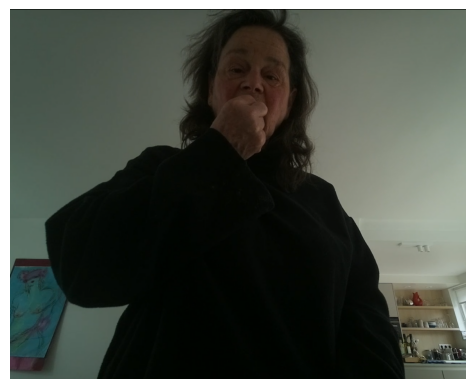

(1373, 1691, 3)


In [71]:
"""
Loading a sample image which i manually uploaded to kaggle in order to test the model
"""

PATH_IMG = "/kaggle/input/sampled/image_2025-04-30_164852098.png"


# Open the PNG image file
image = Image.open(PATH_IMG)

#show image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Convert image to np.array
image_array = np.array(image)

In [66]:
#make and print prediction

classify_action(image_array)

{'calling': 0.105,
 'clapping': 0.128,
 'cycling': 0.009,
 'dancing': 0.06,
 'drinking': 0.246,
 'eating': 0.026,
 'fighting': 0.014,
 'hugging': 0.01,
 'laughing': 0.192,
 'listening_to_music': 0.018,
 'running': 0.005,
 'sitting': 0.03,
 'sleeping': 0.068,
 'texting': 0.054,
 'using_laptop': 0.035}